## Energy Grid for Diatomic Probe (ethane on CuBTC)
Notebook for testing the python code PyIsop_1.0 and its step by step expansion to diatomic probes. Ethane on Cu-BTC as a test case.

In [2]:
import numpy as np
import grid3D
import potentials
import forcefields
import writer


Define and calculate the energy grid for monoatomic probe

In [3]:
t1=grid3D.grid3D('Cu-BTC.cif',spacing=0.5)
f1=forcefields.forcefields(t1,sigma=3.75, epsilon=98) # this is for methane
t2= grid3D.grid3D.grid_calc(t1,"lj",f1)

Calculating grid: Current Z position: 100%|██████████| 52/52 [00:15<00:00,  3.32it/s]


Save the grid for future visualization

In [ ]:
writer.writer.write_vts(t2,'cubtc_grid')
writer.writer.write_frame(t2,'cubtc_repeat.pdb')


Cubic interpolation on the 3D grid data ran into a memory error, so using old linear
interpolation for the time being

In [4]:
pot_interp=grid3D.grid3D.GridInterpolator(t2)
t2.nx_total
pot_interp([0.5,0.5,0.5])

array([-400.26312158])

## Sphere sampling
Let's write sphere sampling around a point x, y, z. The basic idea comes from here
http://mathworld.wolfram.com/SpherePointPicking.html <br>which is based on: <br>Marsaglia, G.
"Choosing a Point from the Surface of a Sphere." Ann. Math. Stat. 43, 645-646, 1972. <br>&<br> Muller,
M. E. "A Note on a Method for Generating Points Uniformly on N-Dimensional Spheres." Comm.
Assoc. Comput. Mach. 2, 19-20, Apr. 1959.

In [5]:
import numpy as np
def sample_spherical(npoints):
    vec = np.random.randn(3, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

Test the sphere sampling approach

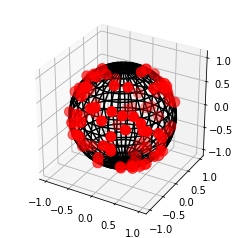

In [6]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))
xi, yi, zi = sample_spherical(100)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(xi, yi, zi, s=100, c='r', zorder=10)
plt.show()

Generate 1000 sampling points on a sphere with radius 1.54 A˚ (ethane). We can translate this
sphere to every or select grid point later.

In [7]:
def boltzman_sphere(point, bondlength, Nsamples, T, grid_obj):
    xi, yi, zi=sample_spherical(Nsamples)*bondlength # Scale the sphere
    sampling_coord = np.column_stack((xi,yi,zi))+point # Translate
    points_in_unit=np.dot(grid_obj.A_inv,sampling_coord.T).T # Put in uni
    points_in_box = points_in_unit-np.floor(points_in_unit) # PBC-- back
    sample_energy = pot_interp(np.around(points_in_box, decimals=3)) # In
    EavgBoltz=np.sum(np.multiply(sample_energy,np.exp(-sample_energy/T)))/np.sum(np.exp(-sample_energy/T))
    return EavgBoltz

Preliminary test on the Boltzmann sphere sampling

In [9]:
pot_interp(np.dot(t2.A_inv,np.array([13,13,13]).T))
boltzman_sphere([10,10,10],1.54,100000,298,t2)

302.17322177304129

Do this for every grid point; we can get away with doing this only over the unit cell. For CuBTC
it's 1x1x1 anyway

In [10]:
from tqdm import tqdm
pot_sphere=np.zeros((t2.nx_total,t2.ny_total,t2.nz_total))
for k in tqdm(range(t2.nz_total),desc='Calculating grid: Current Z position'):
    for j in range(t2.ny_total):
        for i in range(t2.nx_total):
            pot_sphere[i,j,k]=boltzman_sphere([t2.x[i,j,k],t2.y[i,j,k],t2.z[i,j,k]],1.54,100,298,t2)

Calculating grid: Current Z position:   0%|          | 0/52 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
Calculating grid: Current Z position: 100%|██████████| 52/52 [00:50<00:00,  1.02it/s]


Couple of quick sanity checks

In [14]:
np.min(pot_sphere[~np.isnan(pot_sphere)])

-2178.8042463901479

In [13]:
np.min(t2.pot_repeat)
# t2.pot_sphere=pot_sphere

-2267.4965005034019

Tempoarary function to save the spherical energy vtk

In [55]:
def write_vts(grid_obj, path_to_file):
        """ Description
        :type grid_obj: instance of the grid3D class
        :param grid_obj: Contains all the info regarding the energy grid

        :type path_to_file: str
        :param path_to_file: path to the output file including full file name and no extension.

        :raises:

        :rtype: Just writes the file.
        """

        import numpy as np
        from evtk.hl import gridToVTK

        # For we need the grid x, y, z, E style
        # Define the crazy unstructured grid
        #
        dx, dy, dz                                                   = 1.0/grid_obj.nx_total, 1.0/grid_obj.ny_total, 1.0/grid_obj.nz_total
        X                                                            = np.arange(0, 1 + 0.1*dx, dx, dtype='float64')
        Y                                                            = np.arange(0, 1 + 0.1*dy, dy, dtype='float64')
        Z                                                            = np.arange(0, 1 + 0.1*dz, dz, dtype='float64')
        x                                                            = np.zeros((grid_obj.nx_total, grid_obj.ny_total, grid_obj.nz_total))
        y                                                            = np.zeros((grid_obj.nx_total, grid_obj.ny_total, grid_obj.nz_total))
        z                                                            = np.zeros((grid_obj.nx_total, grid_obj.ny_total, grid_obj.nz_total))
        for k in range(grid_obj.nz_total):
                for j in range(grid_obj.ny_total):
                        for i in range(grid_obj.nx_total):
                                x[i, j, k]                           = X[i]
                                y[i, j, k]                           = Y[j]
                                z[i, j, k]                           = Z[k]
        for k in range(grid_obj.nz_total):
                for j in range(grid_obj.ny_total):
                        for i in range(grid_obj.nx_total):
                                [x[i, j, k], y[i, j, k], z[i, j, k]] = np.dot(
                                    grid_obj.A, [x[i, j, k], y[i, j, k], z[i, j, k]])
        #Write pot into .vts file
        gridToVTK(path_to_file, x, y, z, pointData={"Potential": grid_obj.pot_sphere})

Write the sphere sampling as vtk

In [ ]:
write_vts(t2, 'cubtc_sphere')

Add up the energies for a quick sanity check

In [56]:
total=t2.pot_repeat+t2.pot_sphere
np.min(total[~np.isnan(total)]) # Sanity check

-4395.828379829527

Write the total energy grid

In [ ]:
from evtk.hl import gridToVTK
gridToVTK('cubtc_total',t2.x, t2.y, t2.z, pointData={"Potential1": total})


From RASPA simulations<br>

**At 2 bar** (Averages)<br>
>Molecules/UC = 67.627<br>
Average Host-Guest = -145762.13+/- 2465.373<br>
Average Host-Guest per molecule = -2155.38 +/- 36.44<br>
Average Guest-Guest = -27239 +/- 1200<br>
Average guest-guest per molecule = -402.7 +/- 17.74<br>

**At 2 Pa**<br>
>Molecules/UC = 0.0137<br>
Average Host-Guest = -56.58 +/- 15.18<br>
Average Host-Guest per molecule = -4129.92 +/- 1094<br>
Average Guest-Guest = 0<br>
Average guest-guest per molecule = 0<br>
U adsorption = -4284.55<br>

## Energy histogram for diatomic probe
Plot the energy histogram for the ethane molecule from the total grid.

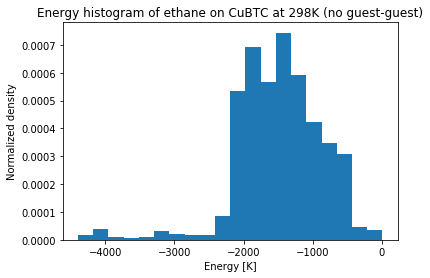

In [57]:
total_clean = total[~np.isnan(total)]
plt.figure(1)
plt.hist(total_clean[total_clean<10],bins=20, density=True)
plt.xlabel('Energy [K]')
plt.ylabel('Normalized density')
plt.title('Energy histogram of ethane on CuBTC at 298K (no guest-guest)')
plt.show()